##### Copyright 2020 The Cirq Developers

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Qubit Placement

This notebooks walks through qubit placement runtime features exposed through the `cirq_google.workflow` tools.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/google/qubit-placement"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/main/docs/google/qubit-placement.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/main/docs/google/qubit-placement.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/google/qubit-placement.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

In [2]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")
    import cirq

installing cirq...


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.1 requires protobuf<4.22,>=4.21.6; python_version < "3.11", but you have protobuf 5.29.5 which is incompatible.


installed cirq.


In [3]:
import numpy as np
from matplotlib import pyplot as plt

## Target Device

First, we get an example target device and---crucially---its qubit connectivity graph.

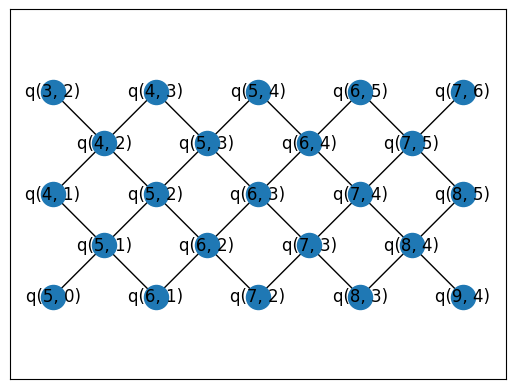

In [4]:
from cirq_google.workflow import SimulatedProcessorWithLocalDeviceRecord

rainbow_record = SimulatedProcessorWithLocalDeviceRecord('rainbow')
rainbow_device = rainbow_record.get_device()
rainbow_graph = rainbow_device.metadata.nx_graph

_ = cirq.draw_gridlike(rainbow_graph, tilted=False)

## Target problem topology

We'll use a `NamedTopology` to talk about the graph connectivity of our circuit. In this case, we'll construct a random circuit on a `cirq.TiltedSquareLattice` topology of a given width and height.

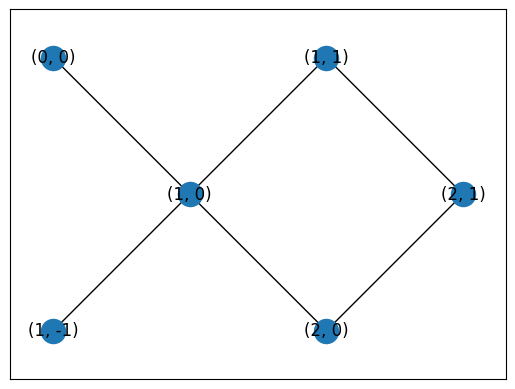

In [5]:
topo = cirq.TiltedSquareLattice(3, 2)
_ = cirq.draw_gridlike(topo.graph, tilted=False)

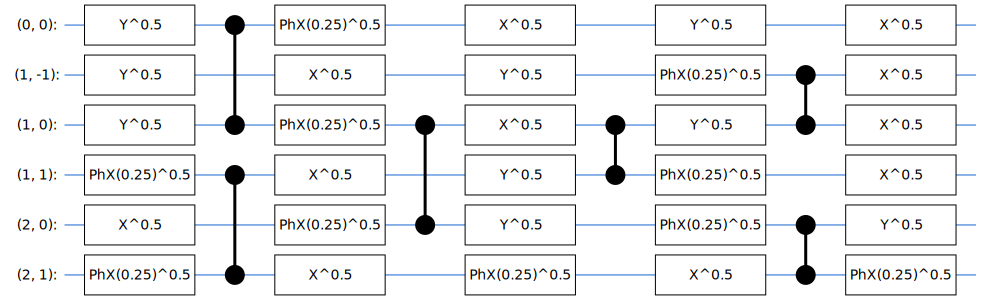

In [6]:
circuit = cirq.experiments.random_rotations_between_grid_interaction_layers_circuit(
    qubits=sorted(topo.nodes_as_gridqubits()), depth=4
)

from cirq.contrib.svg import SVGCircuit

SVGCircuit(circuit)

### Verify circuit connectivity

We use a topology to generate a random circuit. Now we can extract the implied circuit topology from the two qubit gates within to verify that it is indeed the topology we requested:

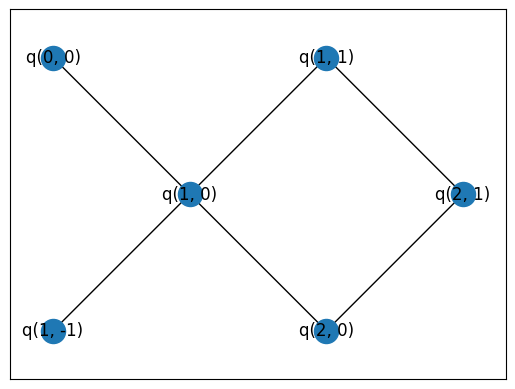

In [7]:
from cirq.contrib.routing import get_circuit_connectivity

circuit_graph = get_circuit_connectivity(circuit)
_ = cirq.draw_gridlike(circuit_graph, tilted=False)

## QubitPlacer

The following classes follow the `QubitPlacer` interface. In particular, there is a method `place_circuit` which maps arbitary input qubits in a circuit to qubits that exist on the device. It accepts a named problem topology and other runtime information to provide more context to the qubit placers.

In [8]:
# set up some other required arguments.
# In a real `cirq_google.workflow.execute()` run, these will be
# handled for you.

from cirq_google.workflow import SharedRuntimeInfo

shared_rt_info = SharedRuntimeInfo(run_id='example', device=rainbow_device)

rs = np.random.RandomState(10)

## RandomDevicePlacer

The `RandomDevicePlacer` will find random, valid placements. On a technical level, this uses networkx subgraph monomorphism routines to map the problem topology to the device graph.

In [9]:
from cirq_google.workflow import NaiveQubitPlacer, RandomDevicePlacer, HardcodedQubitPlacer

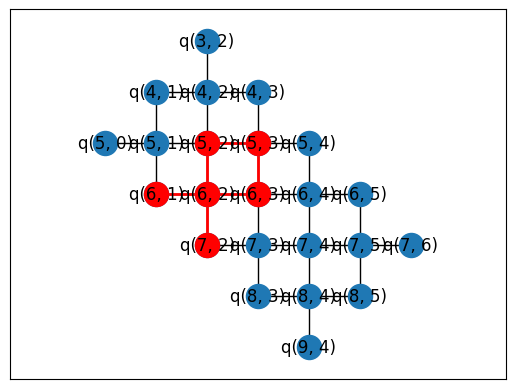

In [10]:
rdp = RandomDevicePlacer()

placed_c, placement = rdp.place_circuit(
    circuit, problem_topology=topo, shared_rt_info=shared_rt_info, rs=rs
)
cirq.draw_placements(rainbow_graph, circuit_graph, [placement])

## NaiveQubitPlacer

As a fallback, you can rely on `NaiveQubitPlacer` which will map input qubits to output qubits. Be careful though! This means you have to choose your qubits as part of circuit construction, which is not advised if you're using `cirq_google.workflow` best practices.

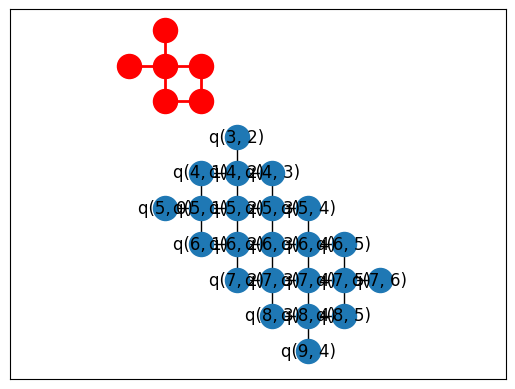

In [11]:
naive = NaiveQubitPlacer()

placed_c, placement = naive.place_circuit(
    circuit, problem_topology=topo, shared_rt_info=shared_rt_info, rs=rs
)
cirq.draw_placements(rainbow_graph, circuit_graph, [placement])

## HardcodedQubitPlacer

If you want ultimate control over qubit placement but still want to decouple your `cg.QuantumExecutable`s from a particular device or configuration, you can use the `HardcodedQubitPlacer` to place your circuits at runtime but from a pre-specified list of valid placements.

Here, we introduce a helper function to generate placements for all `TiltedSquareLattice` topologies anchored from qubit `(4, 2)`.

In [12]:
import itertools


def all_offset_placements(device_graph, offset=(4, 2), min_sidelength=2, max_sidelength=5):
    # Generate candidate tilted square lattice topologies
    sidelens = list(itertools.product(range(min_sidelength, max_sidelength + 1), repeat=2))
    topos = [cirq.TiltedSquareLattice(width, height) for width, height in sidelens]

    # Make placements using TiltedSquareLattice.nodes_to_gridqubits offset parameter
    placements = {topo: topo.nodes_to_gridqubits(offset=offset) for topo in topos}

    # Only allow placements that are valid on the device graph
    placements = {
        topo: mapping
        for topo, mapping in placements.items()
        if cirq.is_valid_placement(device_graph, topo.graph, mapping)
    }
    return placements

The constructor for `HardcodedQubitPlacer` takes in a mapping from named topology to a "placement". Each placement is a mapping from named topology node to device qubit.

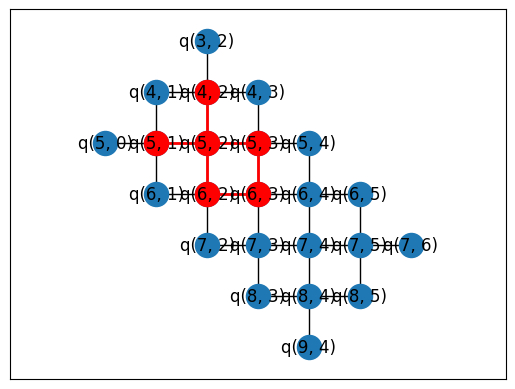

In [13]:
rainbow_mapping = all_offset_placements(rainbow_graph)
hardcoded = HardcodedQubitPlacer(mapping=rainbow_mapping)

placed_c, placement = hardcoded.place_circuit(
    circuit, problem_topology=topo, shared_rt_info=shared_rt_info, rs=rs
)
cirq.draw_placements(rainbow_graph, circuit_graph, [placement])

#### All hardcoded placements

For completeness, the following figure shows all hardcoded placements. If you request one of the supported `TiltedSquareLattice` topology, you'll get the depicted mapping. If you request a topology not in the hardcoded list, you will receive an error. The `RandomDevicePlacer` (in contrast) will always succeed if the topology can be placed on the device.

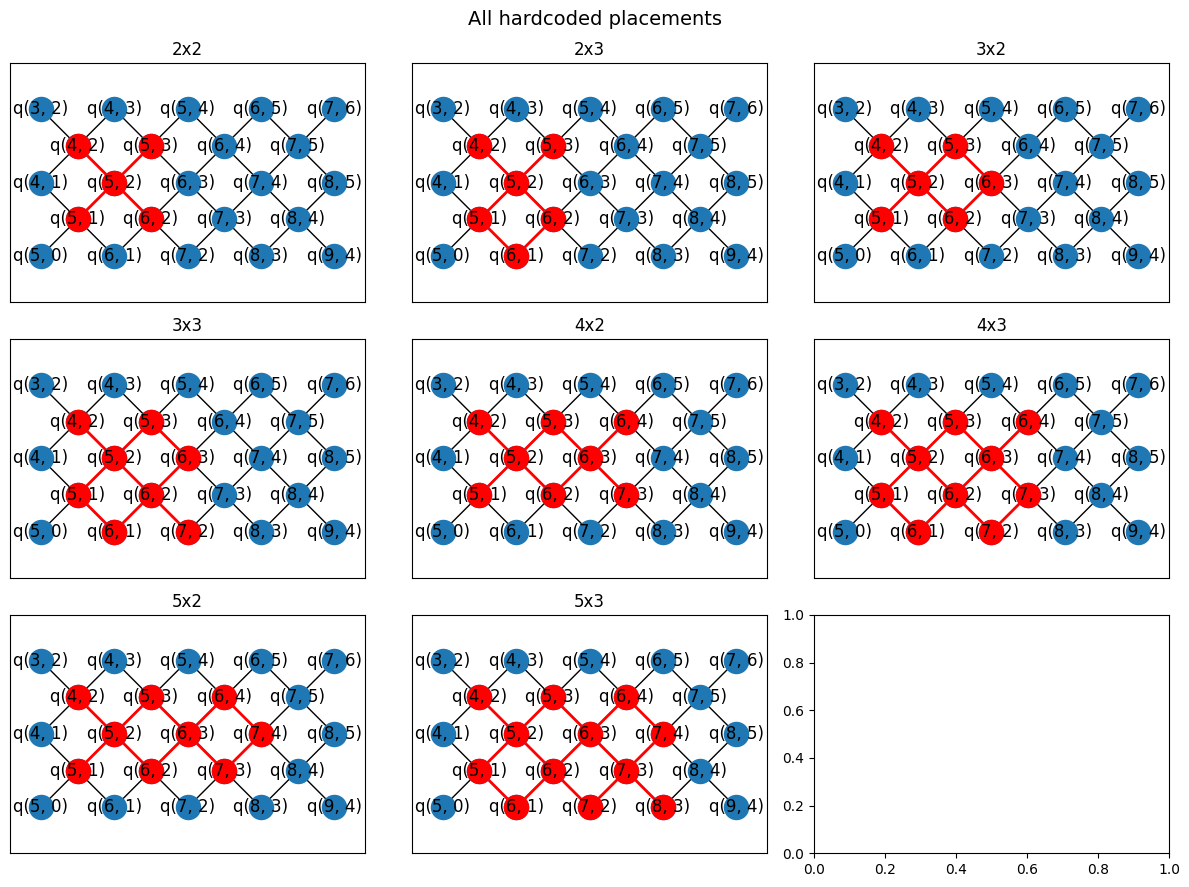

In [14]:
from math import ceil

n_col = 3
n_row = int(ceil(len(rainbow_mapping) / n_col))
fig, axes = plt.subplots(n_row, n_col, figsize=(4 * n_col, 3 * n_row))
axes = axes.reshape(-1)
for i, (topo, mapping) in enumerate(rainbow_mapping.items()):

    axes[i].set_title(f'{topo.width}x{topo.height}')
    cirq.draw_placements(rainbow_graph, topo.graph, [mapping], tilted=False, axes=axes[i : i + 1])

fig.suptitle("All hardcoded placements", fontsize=14)
fig.tight_layout()